In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
from libs import exploring as explore
from libs import visualising as visualize
from libs import cleansing as cleanse

PLOT = True
RUN = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("./data/cleanse/columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import)

food_facts_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710013 entries, 0 to 710012
Data columns (total 22 columns):
code                         709979 non-null object
created_t                    710009 non-null object
created_datetime             710003 non-null object
product_name                 683313 non-null object
quantity                     199912 non-null object
packaging                    143073 non-null object
brands                       473178 non-null object
categories_en                190101 non-null object
origins                      43901 non-null object
origins_tags                 43845 non-null object
manufacturing_places         68814 non-null object
manufacturing_places_tags    68793 non-null object
labels_en                    103325 non-null object
purchase_places              102626 non-null object
stores                       93236 non-null object
countries_en                 709425 non-null object
ingredients_text             397320 non-null object
main_categ

In [50]:
data_summary_string = "The dataset now comprises {} entries, of which we have {} features."
data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1])

'The dataset now comprises 710013 entries, of which we have 22 features.'

# Explore the data
We begin with taking a quick look on the raw data.

In [51]:
food_facts_pd.head(5)

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,origins_tags,...,labels_en,purchase_places,stores,countries_en,ingredients_text,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000000017,1529059080,2018-06-15T10:38:00Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,1569.0,NaN,NaN,NaN
1,0000000000031,1539464774,2018-10-13T21:06:14Z,Cacao,130 g,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,1535737982,2018-08-31T17:53:02Z,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,88.0,NaN,NaN,NaN
3,0000000000178,1542456332,2018-11-17T12:05:32Z,Mini coco,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,251.0,NaN,NaN,NaN
4,0000000000208,1544207680,2018-12-07T18:34:40Z,Pistou d'ail des ours,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN


## Display number of non-NaN entries per column

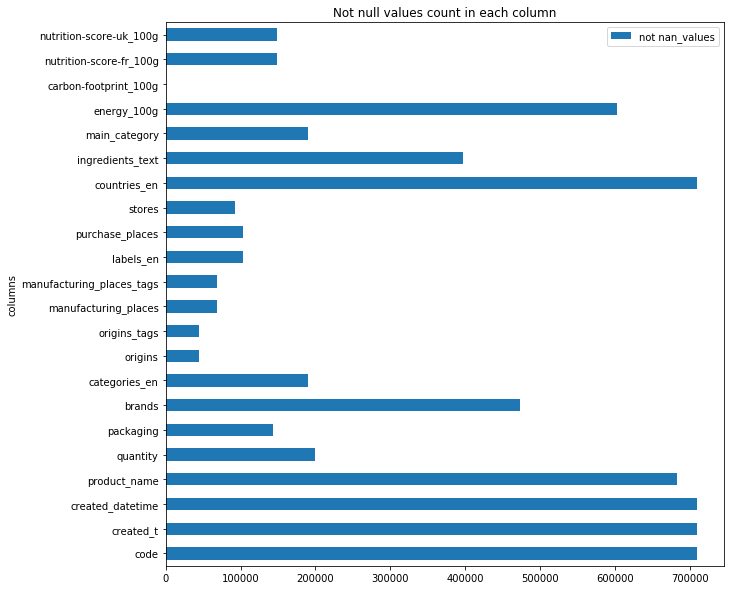

In [52]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'not nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
if PLOT:
    null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
    plt.title("Not null values count in each column")
    plt.show()

Let's also look at the dataset growth over the years:

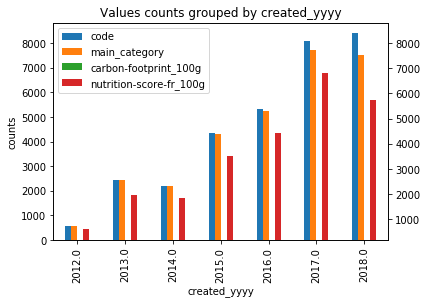

In [53]:
if PLOT:
    food_facts_pd['created_datetime'] = food_facts_pd['created_datetime'].apply(pd.to_datetime, args=('coerce',))
    food_facts_pd['created_yyyy'] = food_facts_pd["created_datetime"].dt.year
    visualize.plot_grouped_counts(food_facts_pd, 'created_yyyy', 
                                  ['code', 'main_category', 'carbon-footprint_100g', 'nutrition-score-fr_100g'])

We see that there are many NaN entries in this data set. For our analysis, we can only use entries that have at least a product name, country tag, manufacturing and purchase place, store, and a created date tag. Unfortunately, we have to drop all columns, that lack these entries.

In [54]:
no_rows_inital = food_facts_pd.shape[0]

# Drop entries with missing entries in one of our main-features
essential_columns = ['created_t', 
                     'product_name', 
                     'countries_en', 
                     'categories_en', 
                     'stores',
                     'manufacturing_places', 
                     'purchase_places']

food_facts_pd = food_facts_pd.dropna(subset=essential_columns, )

no_rows_reduced_nan = food_facts_pd.shape[0]

# Also drop duplicated values (indentify based on index (barcode))
food_facts_pd = food_facts_pd.drop_duplicates()

no_rows_reduced_duplicates = food_facts_pd.shape[0]

print("{} entries were dropped, {} of those were duplicates."\
      .format(no_rows_inital-no_rows_reduced_duplicates, 
              no_rows_reduced_nan-no_rows_reduced_duplicates)
     )
print(data_summary_string.format(food_facts_pd.shape[0], 
                                 food_facts_pd.shape[1]))

667504 entries were dropped, 2 of those were duplicates.
The dataset now comprises 42509 entries, of which we have 23 features.


Puhh, that was though. From now on, we are going to rescue the data and enrich wherever we can.

In [55]:
# Replace NaNs with emptry string
food_facts_pd = food_facts_pd.fillna("")

In [56]:
# Next lets look at the data types:

In [57]:
food_facts_pd.dtypes

code                         object
created_t                    object
created_datetime             object
product_name                 object
quantity                     object
packaging                    object
brands                       object
categories_en                object
origins                      object
origins_tags                 object
manufacturing_places         object
manufacturing_places_tags    object
labels_en                    object
purchase_places              object
stores                       object
countries_en                 object
ingredients_text             object
main_category                object
energy_100g                  object
carbon-footprint_100g        object
nutrition-score-fr_100g      object
nutrition-score-uk_100g      object
created_yyyy                 object
dtype: object

Another thing that we are not really keen of are the language indicators, so we are going to remove those abbreviations.

In [58]:
def remove_language_indicator(row_str):
    tags = [tag if len(tag.split(':'))==1 else tag.split(':')[1] for tag in row_str.split(',')]
    return ",".join(tags)

In [59]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(remove_language_indicator)
food_facts_pd.main_category = food_facts_pd.main_category.apply(remove_language_indicator)
food_facts_pd.countries_en = food_facts_pd.countries_en.apply(remove_language_indicator)
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(remove_language_indicator)

# Cleanse data

## Unitize tags
Many parts of the data are categorizations based on tags. However, those tags are in a variety of languages and string formattings, so in order to use them we attempt to group tags that hint to the same property and map them to a common indicator. 

Every column of the data set requires special treatment, as follows:

### Countries tags

Note :  
- purchase_places and countries_en are the same though "countries_en" has more entries
- manufacturing_places and origins are different

"_Countries_" is a csv file modified in the "_Country__names.ipynb_" file from the source (available at https://mledoze.github.io/countries/). We need to harmonise country names (and push them to English since many entries use French and German). The columns requiring our attentions are the following:
- origins
- manufacturing_places
- countries_en

Note that each have a respective redundant column : origins_tags, manufacturing_places_tags and purchase_places. We are going to filter these by a function in our _cleansing.py_ library to lead to the following respective columns:
- origins_cleaned
- manufacturing_place_cleaned
- purchase_places_cleaned

In [60]:
# Load analyse file
countries = pd.read_csv("./data/country_lookup.csv")[['name', 'cca2', 'alias', 'Forced']]

The following is a test to see how complete the harmonisation is

Now let's attack the Open Food Fact database

In [61]:
#The following commands should not be run except if the analysis has to be performed again. 
#Access the result in ./data/food_facts_pd_countries_names.csv (will be saved to that)
######################################################

In [62]:
if( RUN ):
    food_facts_pd.origins_cleaned = food_facts_pd.origins\
        .apply(lambda x: cleanse.country_name_filter(x, countries))

/Users/ninatubau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [65]:
if( RUN ):
    food_facts_pd.manufacturing_place_cleaned = food_facts_pd.manufacturing_places\
        .apply(lambda x: cleanse.country_name_filter(x, countries))

In [66]:
if( RUN ):
    food_facts_pd.purchase_places_cleaned = food_facts_pd.purchase_places\
        .apply(lambda x: cleanse.country_name_filter(x, countries))

/Users/ninatubau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [68]:
#Let's save these columns so that we don't have to run them again. 

#Do not run this command if you have not processed the whole dataset !
if( RUN ):
    food_facts_pd_countries_names = food_facts_pd[['origins', 
                                                   'manufacturing_places', 
                                                   'purchase_places']
                                                 ]
    food_facts_pd_countries_names.to_csv("./data/food_facts_pd_countries_names.csv")

In [69]:
######################################################

### Labels tags

In [70]:
# Unitze labels
with open('./data/cleanse/taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels_en = food_facts_pd.labels_en.\
    apply(lambda x: ",".join([labels_lookup[z] for z in x.split(',')]))

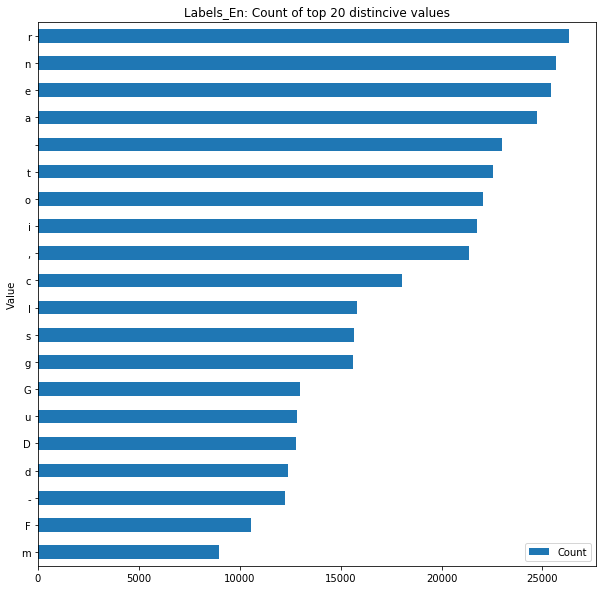

In [71]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'labels_en')

### Store labels tags

In [72]:
# Unitize store labels
with open('./data/cleanse/stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("")\
    .apply(lambda x: ",".join([stores_lookup[z] for z in x.split(',')]))

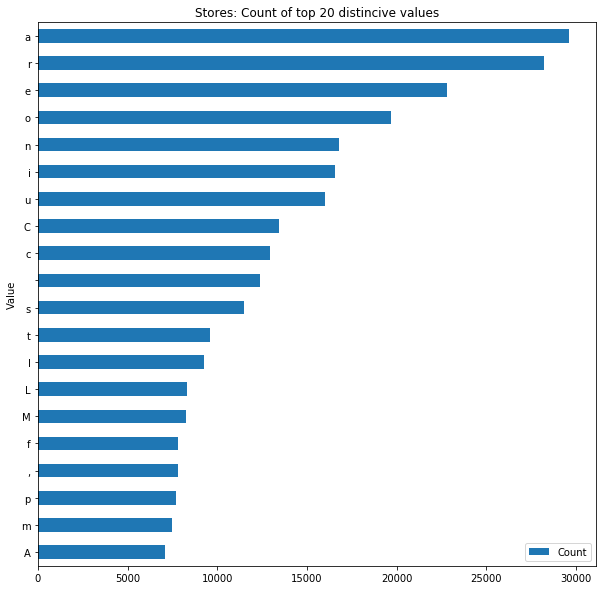

In [73]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'stores')

### Food category tags

In [74]:
# Group categories by user-defined themes
with open('./data/cleanse/categories_en_lookup.json', 'r') as json_data:
    categories_en_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.main_category = food_facts_pd.categories_en.\
    apply(cleanse.group_categories, args=[categories_en_lookup])

In [75]:
# Accumulate all non-specified categories
with open('./data/cleanse/categories_en_lookup.json', 'r') as json_data:
    categories_en = list(json.load(json_data).keys())
food_facts_pd.main_category = food_facts_pd.main_category.\
    apply(cleanse.filter_others, args=[categories_en])    

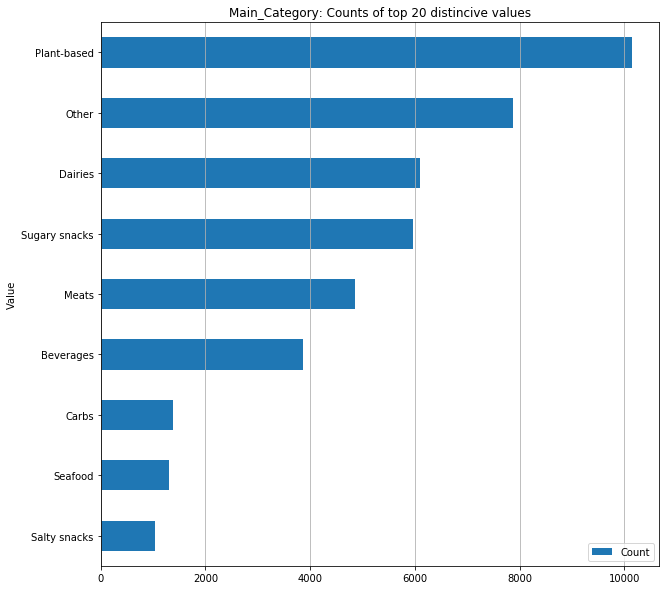

ValueError: too many values to unpack (expected 2)

In [76]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values_from_strings(food_facts_pd, 'main_category')

## Carbon footprint dataset

Because the food facts database lacks carbon footprint specifications, we got random samples of products from Eaternity database. Unfortunately, we were not allowed access to the API before purchasing a 2000 CHF license. However, this weekend, we were given a dataset of carbon footprints for specific products. To use it for our analysis, we have to categorize this products, as they do not match with the food items in the food facts database.

Let's still take a quick look at the Carbon Footprint database, that we have obtained.

### Loading the data

In [77]:
# Import data
carbon_footprint_csv_file = "./data/carbon_footprint.csv"

carbon_footprint_pd = pd.read_csv(carbon_footprint_csv_file, delimiter=",")

#Import data with categories 
# Import data
carbon_footprint_categories_csv_file = "./data/carbon_footprint_categories.csv"

carbon_footprint_categories_pd = pd.read_csv(carbon_footprint_categories_csv_file,delimiter='\t')

In [78]:
print('We have {0} ecological features for {1} products.'\
      .format(carbon_footprint_pd.shape[1], 
              carbon_footprint_pd.shape[0]))

We have 9 ecological features for 692 products.


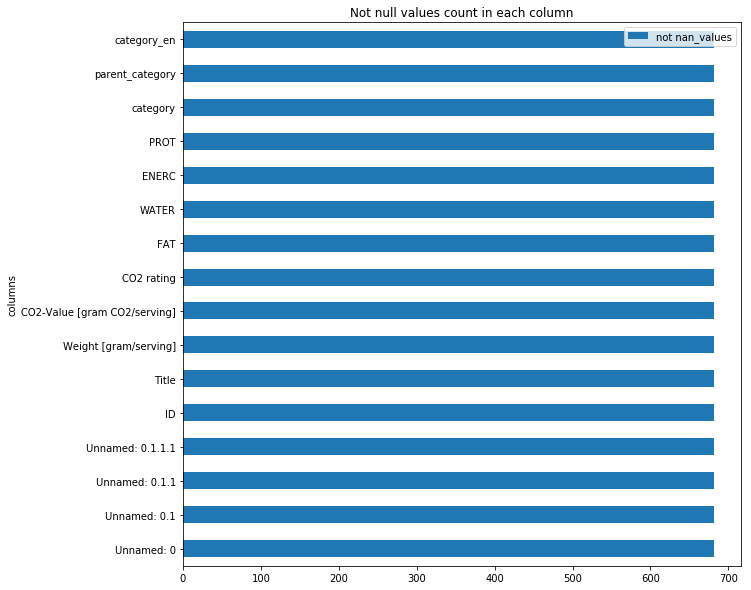

In [108]:
null_entries = pd.DataFrame({'columns' : carbon_footprint_categories_pd.columns,
                             'not nan_values' : [carbon_footprint_categories_pd[c].count() for c in carbon_footprint_categories_pd]
                            })

# Plot NaNs counts
if PLOT:
    null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
    plt.title("Not null values count in each column")
    plt.show()

We clearly see that all the columns of the carbon footprint database from Eaternity are complete.

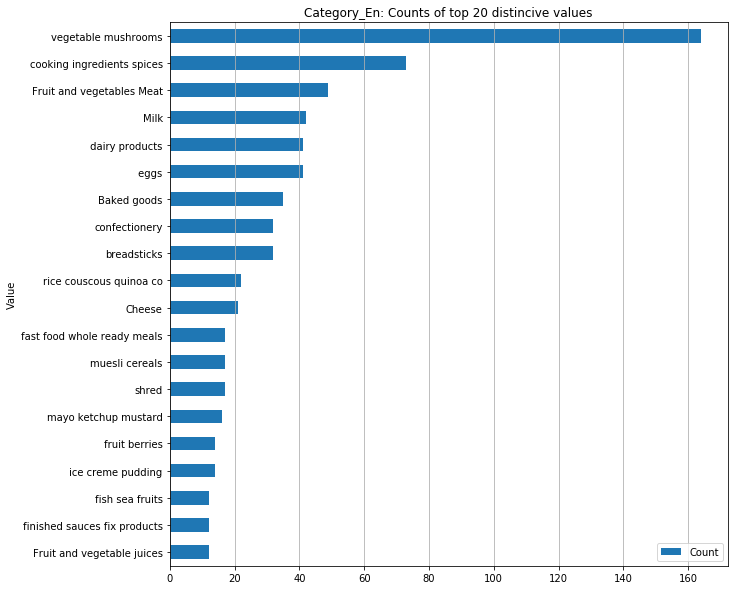

{'mayo ketchup mustard': 16,
 ' dairy products': 41,
 ' eggs': 41,
 'SPREADS': 7,
 'fast food whole ready meals': 17,
 'baking ingredients': 11,
 'Grain': 8,
 'nut plant milk': 6,
 'Fruit and vegetable juices': 12,
 'Eggs.': 2,
 'nuts': 7,
 'Facial skincare': 1,
 'Mineral water': 1,
 'Milk': 42,
 'lemonades refreshment drinks': 1,
 'cocoa drinking chocolate': 3,
 'legumes': 7,
 'Wine and Sparkling Wine': 4,
 'confectionery': 32,
 'muesli cereals': 17,
 'breadsticks': 32,
 'soy saitan meat substitute': 10,
 'Fruit and vegetables Meat': 49,
 'Cheese': 21,
 'Milkshakes': 1,
 'vegetable mushrooms': 164,
 'shred': 17,
 'cooking ingredients spices': 73,
 'fruit berries': 14,
 'finished sauces fix products': 12,
 'seeds koerner': 7,
 'ice creme pudding': 14,
 'rice couscous quinoa co': 22,
 'Baked goods': 35,
 'Syrup': 4,
 'Coffee': 2,
 'fish sea fruits': 12}

In [109]:
visualize.plot_occurences_of_distinct_values_from_strings(carbon_footprint_categories_pd, 'category_en')

Looking at the categories, there are mainly vegetables and condiments. Once we will match with the Open Food Facts database, we will have carbon footprint of food/meals derived from vegetables.

We are interested in the carbon footprint of each product. Because our sample is small (around 700 products) and doesn't really match with the Food Facts Database, we will take care of the categories. Thus, we will extract the categories from [Codecheck website](https://www.codecheck.info/) (Webscraper).

Text(0.5,1,'Distribution of the carbon ')

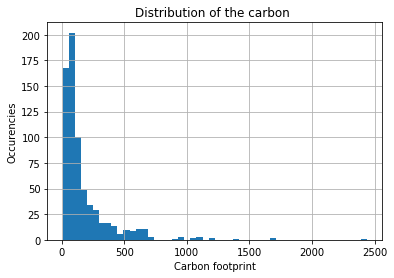

In [80]:
ax = carbon_footprint_pd['CO2-Value [gram CO2/serving]'].hist(bins=50)
ax.set_xlabel('Carbon footprint')
ax.set_ylabel('Occurencies')
ax.set_title('Distribution of the carbon ')

Because the carbon footprint column of the OpenFoodFacts database contains a small amount of data, we will match OpenFoodFacts dataset with the sample given by Eaternity. The approach is the following :
    - Webscrap codeinfo website to get categories and parent categories of each product
    - Translate categories into english
    - Match categories of Open FoodFacts database with parent categories scraped from the website
    - Add the mean value of carbon footprint categories on Open Food Facts database
   

In [110]:
#for the 30 most common categories
food_facts_pd.main_category.value_counts().head(30)

Plant-based      10150
Dairies           6105
Sugary snacks     5961
Meats             4851
Beverages         3862
Carbs             1377
Seafood           1304
Other               11
Salty snacks         1
Name: main_category, dtype: int64

In [111]:
print('Taking into account 30 most important categories represents {0}% of the data'.format(sum(food_facts_pd.main_category.value_counts()[:30])/len(food_facts_pd.main_category)*100))

Taking into account 30 most important categories represents 100.0% of the data


## Concat price info

We also searched online shops for price information about some of the products, that we are going to merge in the following.

In [81]:
prices = pd.read_csv("./web_crawler/data/prices_carbon.csv", dtype={'code':object})

In [82]:
prices_reduced = prices[['product_name', 'price_per_100g', 'store_currency']]

Because the OpenFoodFacts code is not necessarily a global barcode for the product, we had to match the products from the online stores and the entries of the database by teh product name. To be consistent with that method, we merge the prices by the product name.

In [83]:
food_facts_pd = pd.merge(food_facts_pd, prices_reduced, on='product_name', how='left')

In [84]:
print("Product prices successfully merged: {}".format(food_facts_pd.price_per_100g.count()))

Product prices successfully merged: 165


Dict done by hand to match main categories of the OpenFoodFact dataset with the one's found in the sample of Eternity. 

In [112]:
dict_categories = {
   "Plant-based": ['vegetable mushrooms','fruit berries','soy saitan meat substitute','Grain','nuts','seeds koerner','legumes','nut plant milk'],
    "Dairies": ['Milk, dairy products, eggs','Cheese','ice creme pudding'],
    "Sugary snacks":'confectionery',
    "Meats": 'Fruit and vegetables Meat',
    "Beverages":['Fruit and vegetable juices','Wine and Sparkling Wine','Syrup','cocoa drinking chocolate','Coffee','Mineral water','lemonades refreshment drinks','Milkshakes'],
    "Meals":'fast food whole ready meals',
    "Seafood":'fish sea fruits',
    "Groceries":['mayo ketchup mustard','finished sauces fix products','SPREADS'],
    "Carbs":['rice couscous quinoa co','Baked goods','breadsticks','muesli cereals'],
    "Fish And Meat And Eggs":'Eggs.',
    "Baby Foods":'shred',
    "Aliments-D-Origine-Vegetale":['vegetable mushrooms','fruit berries'],
    "Cooking Helpers": ['cooking ingredients spices','baking ingredients']
}

In [113]:
#computing carbon footprint mean for each parent category of Eaternity database
df_mean_carbon_eaternity = cleanse.carbon_mean_eaternity(carbon_footprint_categories_pd)

In [114]:
df_mean_carbon_openff = cleanse.carbon_mean_openff(dict_categories,df_mean_carbon_eaternity)

In [115]:
#complete carbon footprint OpenFoodFacts
for category in dict_categories : 
    condition = ((food_facts_pd.main_category == category) & (food_facts_pd['carbon-footprint_100g'] != None))
    food_facts_pd['carbon-footprint_100g'][condition]=df_mean_carbon_openff[category][0]
    

/Users/ninatubau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [116]:
food_facts_pd = food_facts_pd[food_facts_pd['carbon-footprint_100g'].notna() & 
                                  food_facts_pd['carbon-footprint_100g']!=0]

## Remove negative entries
We have few numerical features, which are the calories (energy), carbon-footprint, and price per 100g of the product. These values are due to physical or economic laws non-negative, which we are going to ensure in the following.

In [85]:
numeric_columns = food_facts_pd.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

food_facts_pd[numeric_columns] = food_facts_pd[numeric_columns].where(food_facts_pd[numeric_columns] >= 0, np.NaN)

# Write clean data frame to CSV file

In [86]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd[['code', 
                              'product_name', 
                              'stores', 
                              'carbon-footprint_100g', 
                              'nutrition-score-fr_100g']
                            ]
    products = products[products['carbon-footprint_100g']!=""]

    products.to_pickle("./web_crawler/data/products_pd.pickle")

Note : country names harmonised are available in ./data/food_facts_pd_countries_names.csv (note the additional code to go back to a list of strings). 

In [87]:
# Apply country name filter

countries_names= pd.read_csv("./data/food_facts_pd_countries_names.csv")
countries_names.origins_cleaned = \
                        countries_names.origins_cleaned.apply(lambda l: cleanse.read(l))

countries_names.manufacturing_place_cleaned = \
                        countries_names.manufacturing_place_cleaned.apply(lambda l: cleanse.read(l))

countries_names.purchase_places_cleaned = \
                        countries_names.purchase_places_cleaned.apply(lambda l: cleanse.read(l))

food_facts_pd = food_facts_pd.drop(['countries_en',
                                   'origins_tags', 
                                    'manufacturing_places_tags',
                                    'purchase_places'],
                                    axis=1)



AttributeError: 'DataFrame' object has no attribute 'origins_cleaned'

In [88]:
food_facts_pd['origins'] = countries_names.origins_cleaned
food_facts_pd['manufacturing_place'] = countries_names.manufacturing_place_cleaned
food_facts_pd['purchase_places'] = countries_names.purchase_places_cleaned
food_facts_pd.head(2)

AttributeError: 'DataFrame' object has no attribute 'origins_cleaned'

In [89]:
food_facts_pd[['origins', 'manufacturing_place', 'purchase_places']] = \
    food_facts_pd[['origins', 'manufacturing_place', 'purchase_places']].fillna("Unknown")

KeyError: "['manufacturing_place'] not in index"

In [ ]:
# Write to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep='\t', encoding='utf-8')

processed_carbon_data_file_name = "./data/carbon_footprint_categories.csv"
carbon_footprint_categories_pd.to_csv(processed_carbon_data_file_name, sep='\t', encoding='utf-8')